# Project Data

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import keras.src.saving.saving_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score

You should consider upgrading via the 'C:\Users\bujowskis\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


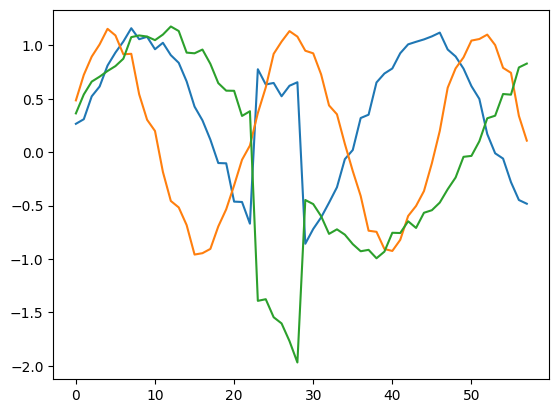

[False False False  True  True]


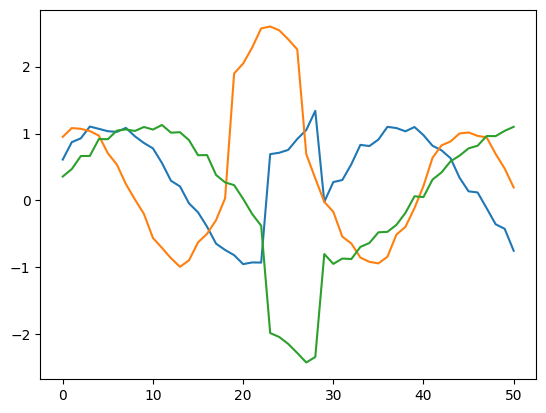

[False False False False False]


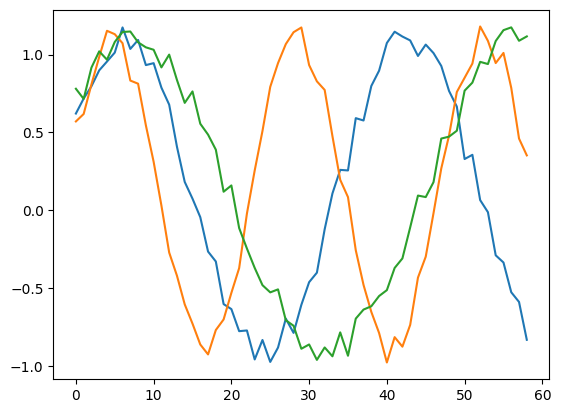

[ True False False False  True]


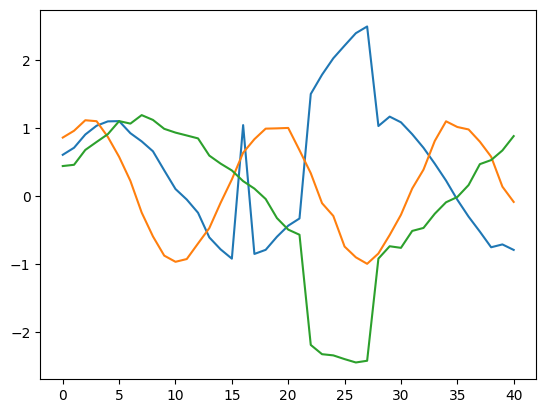

[False  True False False False]


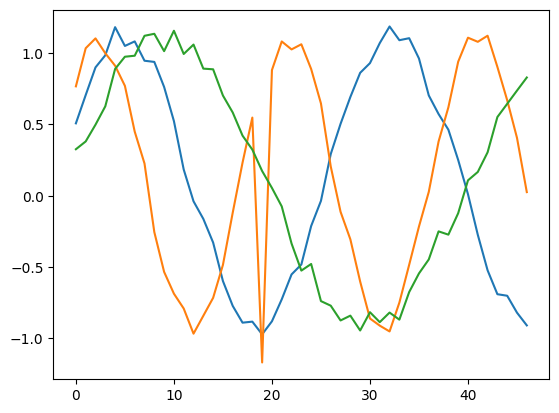

In [6]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

# Solution

In [7]:
print(xl[0])

[[ 0.26629699  0.48574277  0.36391429]
 [ 0.30934984  0.7245592   0.54140266]
 [ 0.52347576  0.8955255   0.66165987]
 [ 0.61586979  1.01015433  0.70790656]
 [ 0.81186389  1.15600173  0.7610961 ]
 [ 0.93386212  1.09415013  0.80695859]
 [ 1.03715876  0.91757752  0.87610299]
 [ 1.16171011  0.92201954  1.0782043 ]
 [ 1.05904494  0.54237835  1.09406918]
 [ 1.08143694  0.30428257  1.08365583]
 [ 0.96480948  0.19900708  1.05009377]
 [ 1.02530106 -0.18445725  1.10219756]
 [ 0.90935975 -0.45634367  1.17807806]
 [ 0.83749434 -0.51709525  1.13542961]
 [ 0.66336656 -0.68251854  0.93317632]
 [ 0.42746462 -0.95853197  0.9268377 ]
 [ 0.29846301 -0.9456677   0.96183929]
 [ 0.11770333 -0.90550167  0.82789007]
 [-0.10127261 -0.69509211  0.64752522]
 [-0.10388178 -0.53451348  0.57683276]
 [-0.46262855 -0.31065108  0.57547318]
 [-0.46604675 -0.07081758  0.33989122]
 [-0.66932554  0.06266696  0.38416678]
 [ 0.77741465  0.3674488  -1.39221771]
 [ 0.63495851  0.60680826 -1.37680454]
 [ 0.6489907   0.9214602 

In [8]:
for i in range(5):
    print(xl[i].shape)

(58, 3)
(51, 3)
(59, 3)
(41, 3)
(47, 3)


## Preprocessing
- padding
- train-test-validation split

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

padding_mask_value = 1000.0
xl_padded = pad_sequences(xl, dtype='float32', padding='post', value=padding_mask_value)
xl_padded_arr = np.array(xl_padded)
yl_arr = np.array(yl, dtype='bool')

# 80-10-10
xl_train, xl_temp, yl_train, yl_temp = train_test_split(xl_padded_arr, yl_arr, test_size=0.2, random_state=42)
xl_test, xl_val, yl_test, yl_val = train_test_split(xl_temp, yl_temp, test_size=0.5, random_state=42)

In [10]:
random_seed = 42

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Masking

# layers
model = Sequential()
model.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
model.add(LSTM(128))
model.add(Dense(5, activation='sigmoid'))  # sigmoid because of binary output
model.summary()

# compile and train
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='acc'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
model.fit(
    xl_train, yl_train,
    validation_data=(xl_val, yl_val),
    epochs=100,
    callbacks=[early_stopping],
    batch_size=10,
    verbose=1
)

# eval
loss, accuracy = model.evaluate(xl_test, yl_test, verbose=2)
print(f'\tAccuracy: {accuracy}')
print(f'\tLoss: {loss}')

model.save('class-lstm128.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4000/4000 [==============================] - 50s 12ms/step - loss: 0.3111 - acc: 0.4140 - val_loss: 0.2582 - val_acc: 0.4420
Epoch 2/100
4000/4000 [==============================] - 53s 13ms/step - loss: 0.1988 - acc: 0.4803 - val_loss: 0.1470 - val_acc: 0.5010
Epoch 3/

C:\Users\bujowskis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import keras
from keras.src.saving.saving_lib import load_model

random_seed = 42

model = load_model('class-lstm128.keras')

In [10]:
def convert_prediction(prediction: np.array):
    """
    Given real-valued output of the model, this converts it to True/False based on threshold
    """
    return np.where(prediction > 0.5, True, False)

In [14]:
# check predictions manually
for predicted, actual in zip(model.predict(xl_padded_arr[:3]), yl_arr[:3]):
    print(f'predicted:\t{convert_prediction(predicted)}')
    print(f'actual:\t\t{actual}')
    print('***')

1/1 [==============================] - 2s 2s/step
predicted:	[False False False False  True]
actual:		[False False False False  True]
***
predicted:	[False False False  True  True]
actual:		[False False False  True  True]
***
predicted:	[False False False False False]
actual:		[False False False False False]
***


In [15]:
test_predictions_converted = [convert_prediction(prediction) for prediction in model.predict(xl_test)]
accuracy_on_converted = np.mean(test_predictions_converted == yl_test)
print(f'Accuracy on converted: {accuracy_on_converted}')

157/157 [==============================] - 2s 15ms/step
Accuracy on converted: 0.99924


In [ ]:
# todo - autoencoder (TimeDistributed)
# - sequence to sequence prediction
# - spotting defects between prediction and actual (potential anomalies)
# - mark difference
# todo - autoencoder-decoder to mark sequences where error is detected
#   - encode-decode - result in sequence
#   - compare actual data to result -> find anomalies -> mark anomalies (heuristics?)

In [35]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RepeatVector, Masking, TimeDistributed, Dense

random_seed = 42

# arch
input_shape = xl_train[0].shape
padded_sequence_length = input_shape[0]
autoencoder = Sequential()
autoencoder.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
autoencoder.add(LSTM(128))
autoencoder.add(RepeatVector(padded_sequence_length))
autoencoder.add(LSTM(64, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(input_shape[1]))) 
autoencoder.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error']
)
autoencoder.summary()

# training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
autoencoder.fit(
    xl_train, xl_train,
    epochs=100,
    batch_size=10,
    callbacks=early_stopping,
    shuffle=True,
    validation_data=(xl_val, xl_val)
)

autoencoder.save('autoencoder.keras')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_14 (Masking)        (None, 59, 3)             0         
                                                                 
 lstm_20 (LSTM)              (None, 128)               67584     
                                                                 
 repeat_vector_10 (RepeatVe  (None, 59, 128)           0         
 ctor)                                                           
                                                                 
 lstm_21 (LSTM)              (None, 59, 64)            49408     
                                                                 
 time_distributed_5 (TimeDi  (None, 59, 3)             195       
 stributed)                                                      
                                                                 
Total params: 117187 (457.76 KB)
Trainable params: 11

In [36]:
# eval
loss, mse, mae = autoencoder.evaluate(xl_test, xl_test, verbose=2)
print(f'\tMean Squared Error: {mse}')
print(f'\tMean Absolute Error: {mae}')
print(f'\tLoss: {loss}')

# loss = autoencoder.evaluate(xl_test, xl_test, verbose=2)
# print(f'\tLoss: {loss}')

157/157 - 3s - loss: 3283.5676 - mean_squared_error: 3283.5681 - mean_absolute_error: 23.6486 - 3s/epoch - 16ms/step
	Mean Squared Error: 3283.568115234375
	Mean Absolute Error: 23.64861297607422
	Loss: 3283.567626953125


In [37]:
autoencoder_predictions = autoencoder.predict(xl_test)

157/157 [==============================] - 3s 12ms/step


In [38]:
print(autoencoder_predictions[0])

[[ 1.7762384e+00  1.5930214e+00  1.7383337e+00]
 [ 2.7663231e-02 -1.4721775e-01 -3.4809113e-04]
 [-5.7186413e-01 -7.4615192e-01 -5.9822750e-01]
 [-6.6989040e-01 -8.4580898e-01 -6.9551754e-01]
 [-5.8367157e-01 -7.6205826e-01 -6.0902882e-01]
 [-4.7225380e-01 -6.5344810e-01 -4.9765491e-01]
 [-3.8195038e-01 -5.6606483e-01 -4.0761948e-01]
 [-3.1963253e-01 -5.0667095e-01 -3.4574413e-01]
 [-2.8046036e-01 -4.7039318e-01 -3.0715752e-01]
 [-2.5750446e-01 -4.5028687e-01 -2.8486824e-01]
 [-2.4492931e-01 -4.4049454e-01 -2.7300549e-01]
 [-2.3860168e-01 -4.3690205e-01 -2.6742077e-01]
 [-2.3589230e-01 -4.3685246e-01 -2.6545429e-01]
 [-2.3518944e-01 -4.3873024e-01 -2.6551247e-01]
 [-2.3556042e-01 -4.4159603e-01 -2.6663876e-01]
 [-2.3644066e-01 -4.4488049e-01 -2.6828671e-01]
 [-2.3747158e-01 -4.4817448e-01 -2.7008057e-01]
 [-2.3839188e-01 -4.5122242e-01 -2.7178669e-01]
 [-2.3899746e-01 -4.5378113e-01 -2.7318478e-01]
 [-2.3911190e-01 -4.5565414e-01 -2.7411556e-01]
 [-2.3855400e-01 -4.5662975e-01 -2.74403

Defects in xl_test[0]: [False False False  True  True]


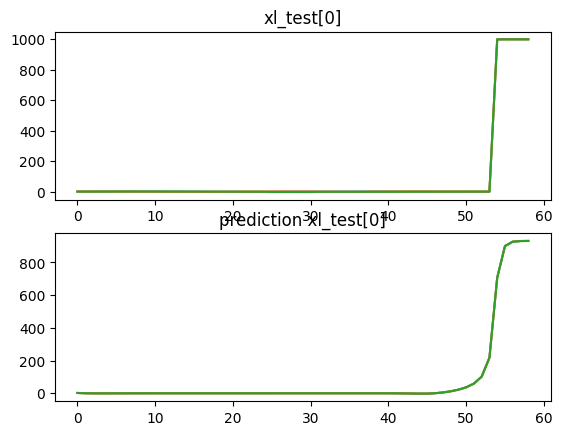

Defects in xl_test[1]: [False False False False False]


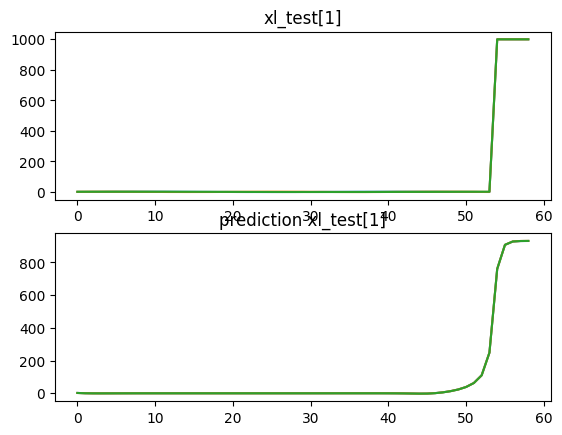

Defects in xl_test[2]: [False  True  True False False]


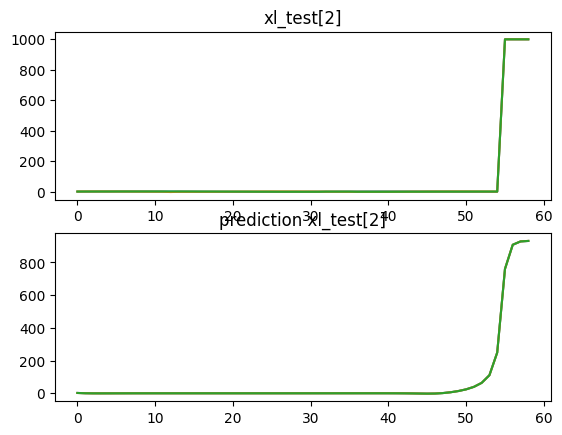

Defects in xl_test[3]: [ True False False False False]


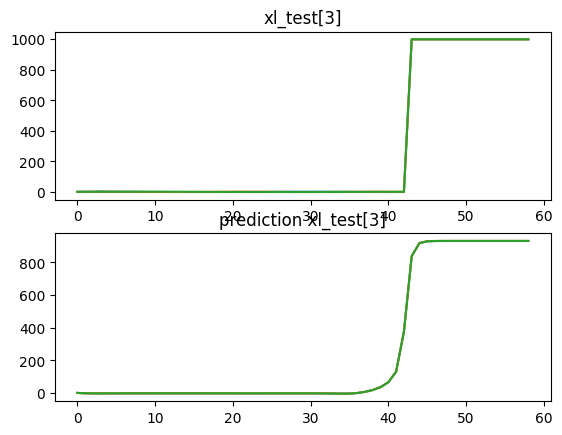

Defects in xl_test[4]: [False False False False False]


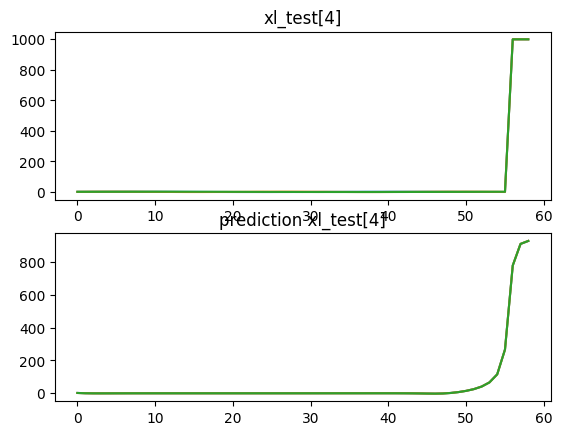

In [40]:
for i in range(5):
    print(f'Defects in xl_test[{i}]: {yl_test[i]}')
    plt.subplot(2, 1, 1)
    plt.plot(xl_test[i])
    plt.title(f'xl_test[{i}]')

    plt.subplot(2, 1, 2)
    plt.plot(autoencoder_predictions[i])
    plt.title(f'prediction xl_test[{i}]')

    plt.show()

Defects in xl_test[0]: [False False False  True  True]


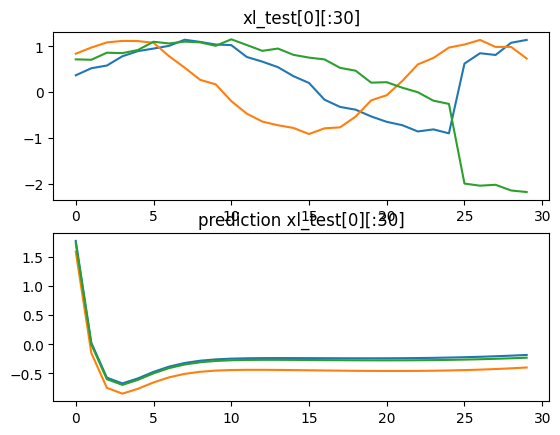

Defects in xl_test[1]: [False False False False False]


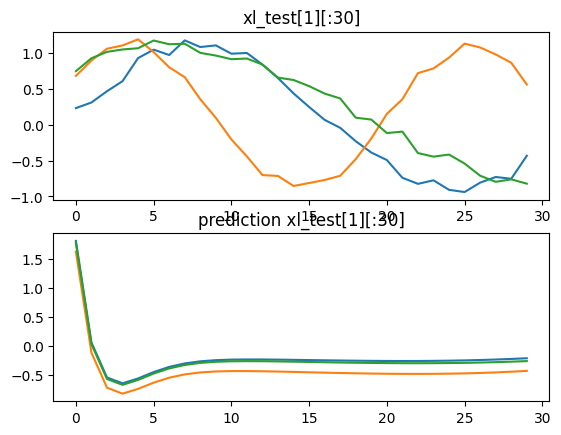

Defects in xl_test[2]: [False  True  True False False]


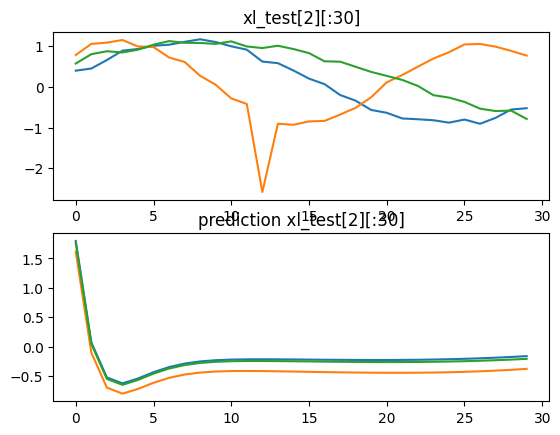

Defects in xl_test[3]: [ True False False False False]


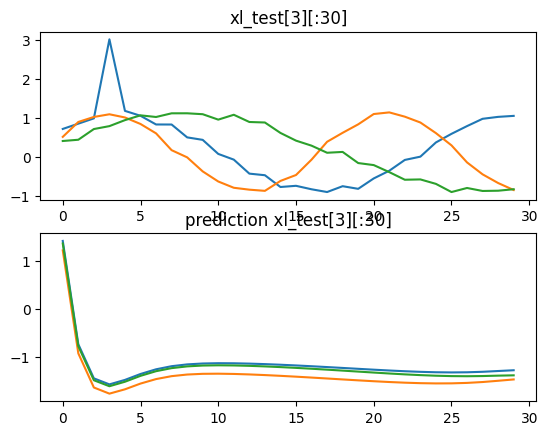

Defects in xl_test[4]: [False False False False False]


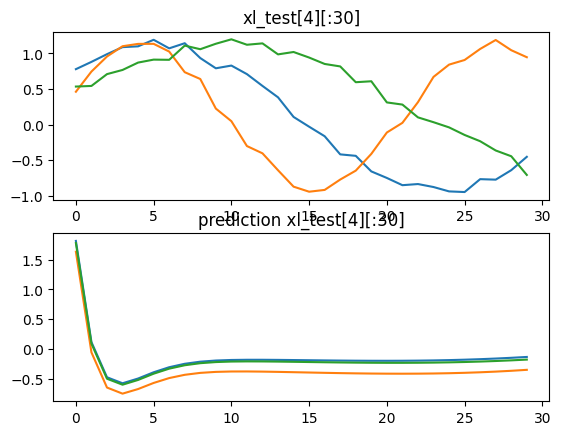

In [47]:
for i in range(5):
    print(f'Defects in xl_test[{i}]: {yl_test[i]}')
    plt.subplot(2, 1, 1)
    plt.plot(xl_test[i][:30])
    plt.title(f'xl_test[{i}][:30]')

    plt.subplot(2, 1, 2)
    plt.plot(autoencoder_predictions[i][:30])
    plt.title(f'prediction xl_test[{i}][:30]')

    plt.show()

In [50]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RepeatVector, Masking

random_seed = 42

# architecture
input_shape = xl_train[0].shape
padded_sequence_length = input_shape[0]
autoencoder = Sequential()
# encoding
autoencoder.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
autoencoder.add(LSTM(128))
# decoding
autoencoder.add(RepeatVector(padded_sequence_length))
autoencoder.add(LSTM(input_shape[1], return_sequences=True))
autoencoder.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error']
)
autoencoder.summary()

# training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
autoencoder.fit(
    xl_train, xl_train,
    epochs=100,
    batch_size=100,
    callbacks=early_stopping,
    shuffle=True,
    validation_data=(xl_val, xl_val)
)

autoencoder.save('autoencoder-2.keras')

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_17 (Masking)        (None, 59, 3)             0         
                                                                 
 lstm_25 (LSTM)              (None, 128)               67584     
                                                                 
 repeat_vector_13 (RepeatVe  (None, 59, 128)           0         
 ctor)                                                           
                                                                 
 lstm_26 (LSTM)              (None, 59, 3)             1584      
                                                                 
Total params: 69168 (270.19 KB)
Trainable params: 69168 (270.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
400/400 [==============================] - 20s 42ms/step - loss: 1603

In [51]:
autoencoder_predictions = autoencoder.predict(xl_test)

157/157 [==============================] - 3s 10ms/step


Defects in xl_test[0]: [False False False  True  True]


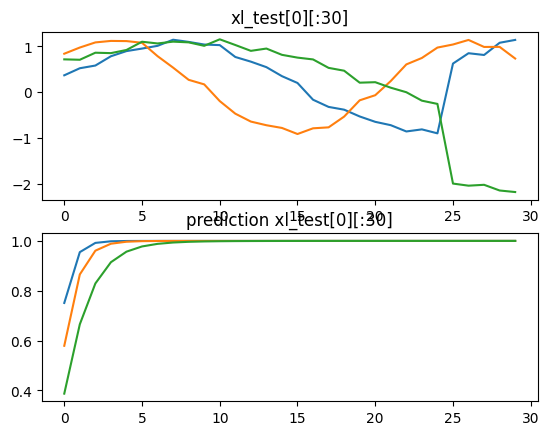

Defects in xl_test[1]: [False False False False False]


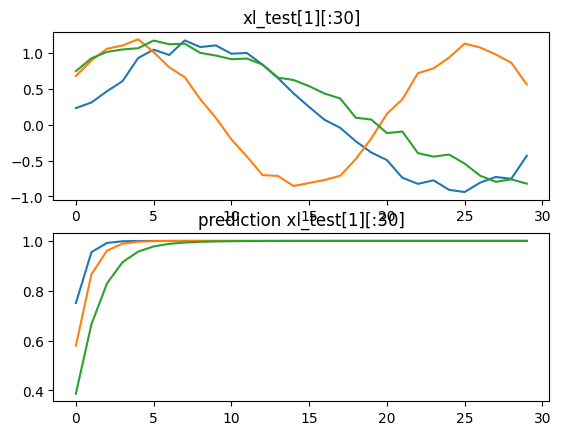

Defects in xl_test[2]: [False  True  True False False]


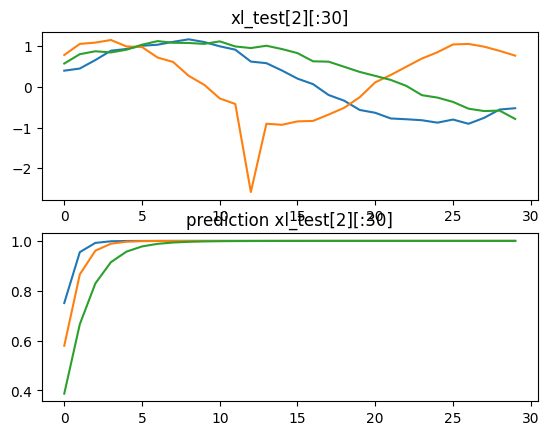

Defects in xl_test[3]: [ True False False False False]


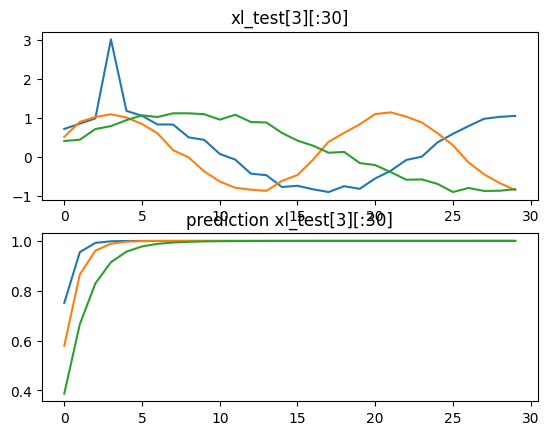

Defects in xl_test[4]: [False False False False False]


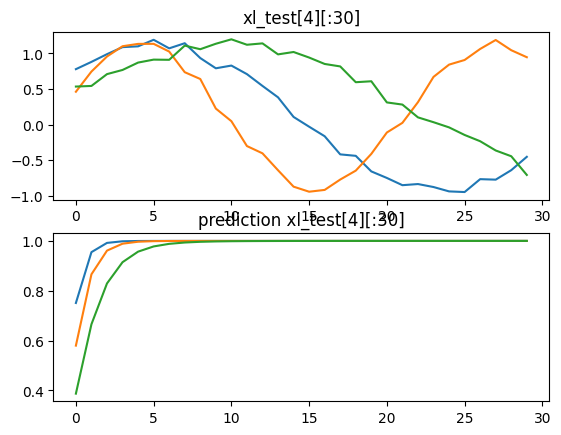

In [52]:
for i in range(5):
    print(f'Defects in xl_test[{i}]: {yl_test[i]}')
    plt.subplot(2, 1, 1)
    plt.plot(xl_test[i][:30])
    plt.title(f'xl_test[{i}][:30]')

    plt.subplot(2, 1, 2)
    plt.plot(autoencoder_predictions[i][:30])
    plt.title(f'prediction xl_test[{i}][:30]')

    plt.show()

In [96]:
@keras.saving.register_keras_serializable()
def custom_masked_loss(y_true, y_pred, mask_value=1000):
    # Create a binary mask where 1 indicates unmasked values and 0 indicates masked values
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    # Calculate mean squared error only on unmasked values
    return K.mean(K.square((y_true - y_pred) * mask), axis=-1)

In [136]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, RepeatVector, Masking, Dense, Bidirectional, Dropout, BatchNormalization
from keras import backend as K

random_seed = 42

# architecture
input_shape = xl_train[0].shape
padded_sequence_length = input_shape[0]
autoencoder = Sequential()
# encoding
autoencoder.add(Masking(mask_value=padding_mask_value, input_shape=xl_train[0].shape))
autoencoder.add(Bidirectional(LSTM(16, return_sequences=True)))
autoencoder.add(LSTM(16))
autoencoder.add(BatchNormalization())
# decoding
autoencoder.add(RepeatVector(padded_sequence_length))
autoencoder.add(Bidirectional(LSTM(16, return_sequences=True))) # todo - return_sequences=False, or even just Dense?
autoencoder.add(Dropout(0.5))
autoencoder.add(Dense(input_shape[1], activation='linear'))
autoencoder.add(BatchNormalization())

autoencoder.compile(
    optimizer='adam',
    loss=custom_masked_loss,
    metrics=['mean_squared_error', 'mean_absolute_error']
)
autoencoder.summary()

# training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
autoencoder.fit(
    xl_train, xl_train,
    epochs=100,
    batch_size=10, # todo - back to 10? to 5
    callbacks=early_stopping,
    shuffle=True,
    validation_data=(xl_val, xl_val)
)

autoencoder.save('autoencoder-custom-loss-batch-normalization-16-16-16-drop05.keras')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_35 (Masking)        (None, 59, 3)             0         
                                                                 
 bidirectional_14 (Bidirect  (None, 59, 32)            2560      
 ional)                                                          
                                                                 
 lstm_71 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_6 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 repeat_vector_30 (RepeatVe  (None, 59, 16)            0         
 ctor)                                                           
                                                     

In [113]:
autoencoder = load_model('autoencoder-custom-loss-complex-arch.keras')

In [137]:
autoencoder_predictions = autoencoder.predict(xl_test)

157/157 [==============================] - 4s 8ms/step


In [67]:
print(autoencoder_predictions.shape)

(5000, 59, 3)


In [90]:
import matplotlib.pyplot as plt

# Assuming xl_test and autoencoder_predictions are NumPy arrays
# with sequences to be plotted

def plot_comparison(sample_index, predictions):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot original sequence
    xl_test_to_plot = xl_test[sample_index][:30]
    axes[0].plot(xl_test_to_plot)
    axes[0].set_title('Original')
    
    # Plot autoencoder prediction
    autoencoder_prediction_to_plot = predictions[sample_index][:30]
    axes[1].plot(autoencoder_prediction_to_plot)
    axes[1].set_title('Autoencoder Prediction')

    # Set y-axis limits to be the same for both subplots
    y_min = min(xl_test_to_plot.min(), autoencoder_prediction_to_plot.min())
    y_max = max(xl_test_to_plot.max(), autoencoder_prediction_to_plot.max())

    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)

    # Add labels, title, etc., as needed
    plt.tight_layout()
    plt.show()
    print(f'Defects in xl_test[{sample_index}]: {yl_test[sample_index]}')

In [97]:
from keras.src.saving.saving_lib import load_model

a256_128 = load_model('autoencoder-custom-loss-lstm256-dense128.keras')
autoencoder_predictions_lstm256_dense128 = a256_128.predict(xl_test)
# fixme - wrong loss function? error within it? (not capturing all dimensions?)

157/157 [==============================] - 4s 19ms/step


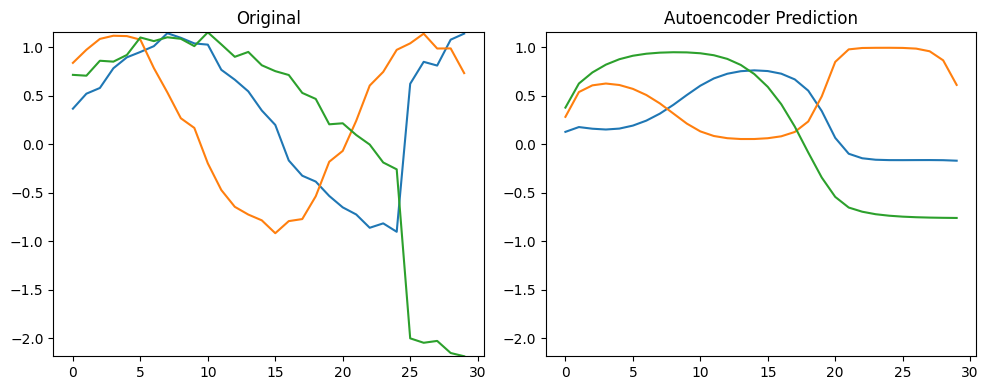

Defects in xl_test[0]: [False False False  True  True]


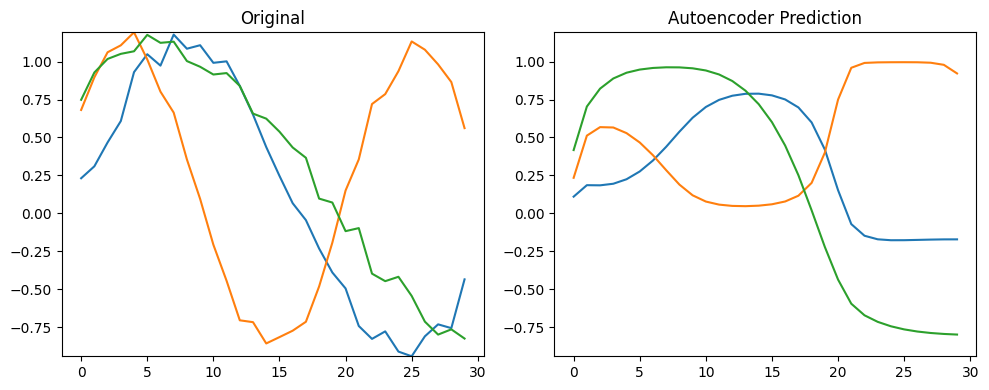

Defects in xl_test[1]: [False False False False False]


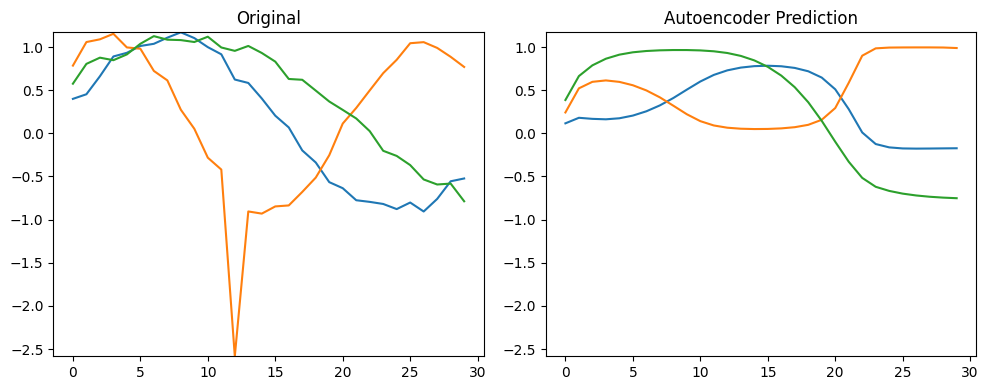

Defects in xl_test[2]: [False  True  True False False]


In [138]:
for i in range(0, 3):
    plot_comparison(i, autoencoder_predictions_lstm256_dense128)

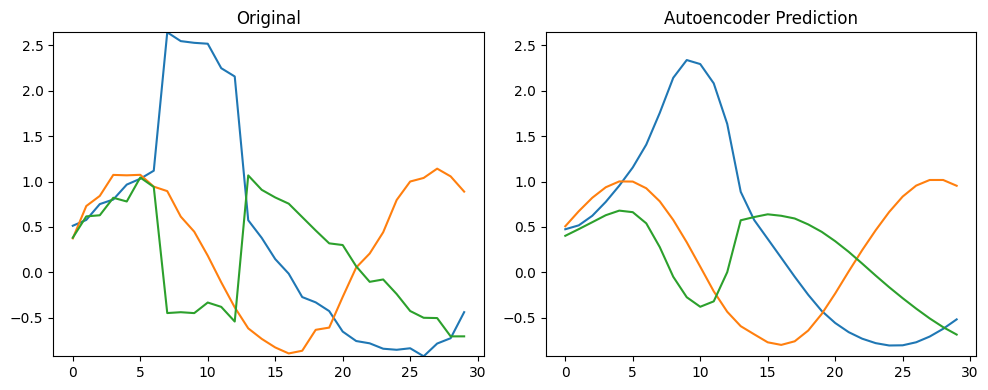

Defects in xl_test[100]: [False False False False  True]


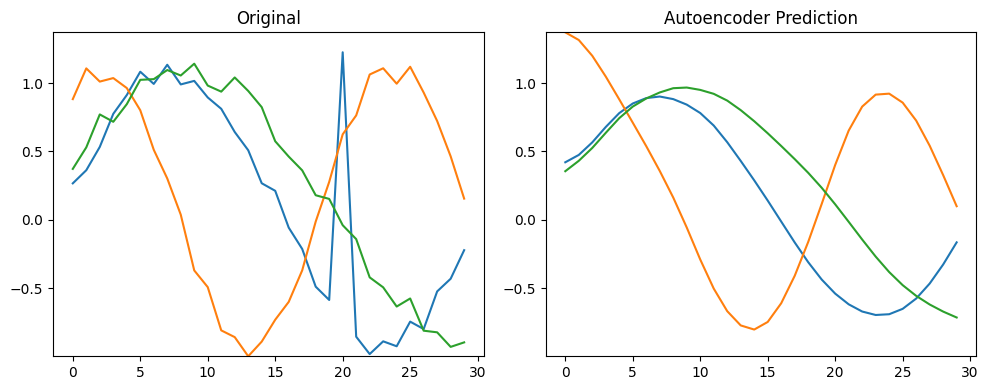

Defects in xl_test[101]: [ True False False  True False]


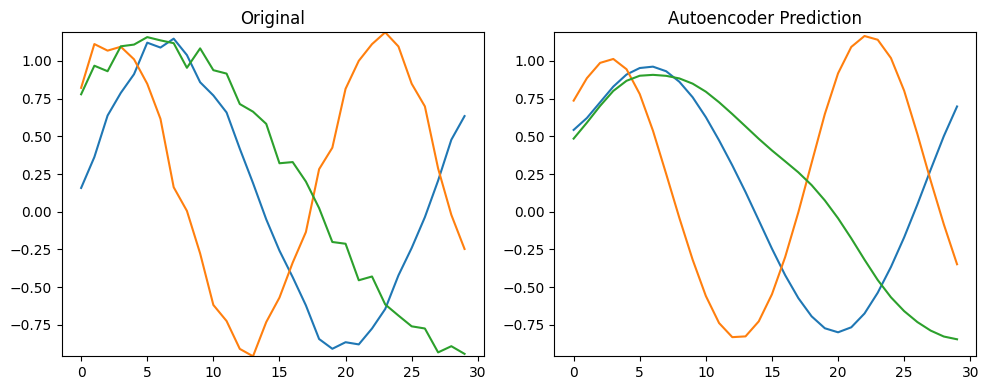

Defects in xl_test[102]: [False  True False False False]


In [139]:
for i in range(100, 103):
    plot_comparison(i, autoencoder_predictions)